# Analyse BlueSeis BSPF Events

With pressure sensor parascientific and new sensor 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

## Configurations

In [2]:
config = {}

config['minlatitude'] = 31
config['maxlatitude'] = 35
config['minlongitude'] = -119
config['maxlongitude'] = -114

config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

config['minmagnitude'] = 2.5

config['tbeg'] = obs.UTCDateTime("2022-10-01")
config['tend'] = obs.UTCDateTime("2023-03-20")

config['eventfile'] = "BSPF_event_catalog.pkl"

config['outpath'] = "./"

In [3]:
def __export_new_events(config, events_old, events):
    
    ## combine new and old catalog
    tmp = pd.concat([__cat_to_df(events_old), __cat_to_df(events)]).reset_index(drop=False)
    ## remove duplicates
    df = tmp.drop_duplicates(subset=['index'], keep=False)
    ## sort and set index
    df = df.sort_index(ascending=False)
    df.set_index('index', inplace=True, drop=True)
    
    ## export new events to pickle file
    print(f" -> export new events: {config['outpath']}new_events.pkl")
    df.to_pickle(config['outpath']+"new_events.pkl")
    
    del tmp, df  

In [4]:
def __cat_to_df(cat):
    
    from pandas import DataFrame
    
    times = []
    lats = []
    lons = []
    deps = []
    magnitudes = []
    magnitudestype = []
    
    for event in cat:
        if len(event.origins) != 0 and len(event.magnitudes) != 0:
            times.append(event.origins[0].time.datetime)
            lats.append(event.origins[0].latitude)
            lons.append(event.origins[0].longitude)
            deps.append(event.origins[0].depth)
            magnitudes.append(event.magnitudes[0].mag)
            magnitudestype.append(event.magnitudes[0].magnitude_type )
            
    df = DataFrame({'latitude':lats,'longitude':lons,'depth':deps,
                    'magnitude':magnitudes,'type':magnitudestype}, 
                     index = times
                  )
    
    return df

In [5]:
def __add_distances_and_backazimuth(config, df):

    from obspy.geodetics.base import gps2dist_azimuth

    dist = np.zeros(len(df))
    baz = np.zeros(len(df))

    
    for ii, ev in enumerate(df.index):
        try:
            dist[ii], az, baz[ii] = gps2dist_azimuth(config['BSPF_lat'], config['BSPF_lon'],
                                                     df.latitude[ii], df.longitude[ii],
                                                     a=6378137.0, f=0.0033528106647474805
                                                     )
        except:
            print(" -> failed to compute!")
            
    df['backazimuth'] = baz
    df['distances_km'] = dist/1000

    return df

## Get Events

In [24]:
client = Client("USGS")

## events - all in area and time period
events_all = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
                               minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
                               starttime=config['tbeg'],
                               endtime=config['tend'],
                               )

# ## events smaller than 2.0
# events_1 = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
#                              minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
#                              starttime=config['tbeg'],
#                              endtime=config['tend'],
#                              maxmagnitude=2.0,
#                             )

## events between 2.0 and 3.0 within distance 0.5 degrees
events_2 = client.get_events(
                             latitude=config['BSPF_lat'], longitude=config['BSPF_lon'],
                             starttime=config['tbeg'],
                             endtime=config['tend'],
                             minmagnitude=2.0,
                             maxmagnitude=3.0,
                             maxradius=0.5,
                            )

## events between 2.0 and 3.0 within distance 2.0 degrees
events_3 = client.get_events(
                             latitude=config['BSPF_lat'], longitude=config['BSPF_lon'],
                             starttime=config['tbeg'],
                             endtime=config['tend'],
                             minmagnitude=3.0,
                             maxmagnitude=5.0,
                             maxradius=5.0,
                            )

## events larger than 5.0 
events_4 = events_all.filter("magnitude > 5.0")


## join specified event catalogs together
events = events_2 + events_3 + events_4


# events.plot(projection="local");

# events.write(config['outpath']+"events.xml", format="QUAKEML")

In [156]:
## convert catalog object to data frame
events_df = __cat_to_df(events)
events_all_df = __cat_to_df(events_all)

## add epicentral distances
__add_distances_and_backazimuth(config, events_df)
__add_distances_and_backazimuth(config, events_all_df)

## write data frame as pickle file
events_df.to_pickle(config['outpath']+config['eventfile'])

## Plot Event Timeline

In [158]:
events_all_df = events_all_df.rename_axis('timestamp').reset_index()
events_all_df['seconds'] = [abs((events_all_df.timestamp.min()-tt).total_seconds()) for tt in events_all_df.timestamp]

events_df = events_df.rename_axis('timestamp').reset_index()
events_df['seconds'] = [abs((events_df.timestamp.min()-tt).total_seconds()) for tt in events_df.timestamp]
events_df



,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
0,2023-03-10 15:02:31.670,33.395333,-116.391167,3750.0,2.42,ml,345.977070,24.616176,13800948.14
1,2023-03-10 06:49:37.800,33.696333,-116.720500,17820.0,2.56,ml,111.061528,26.359703,13771374.27
2,2023-03-10 01:13:29.650,33.465333,-116.569667,9430.0,2.30,ml,33.325225,19.295583,13751206.12
3,2023-03-09 11:49:06.640,34.047333,-116.350833,7120.0,2.03,ml,191.334327,49.395803,13702943.11
4,2023-03-08 04:07:32.850,34.047833,-116.350833,6790.0,2.77,ml,191.321698,49.450184,13588849.32
...,...,...,...,...,...,...,...,...,...
147,2022-10-07 22:45:05.470,33.041333,-116.354667,11790.0,3.47,mlr,351.575554,63.835594,523101.94
148,2022-10-05 04:51:30.350,37.327833,-120.041167,19550.0,3.01,ml,140.666788,525.267022,285886.82
149,2022-10-04 16:38:33.910,32.338167,-115.244333,2830.0,3.57,ml,321.590002,180.919294,241910.38
150,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,128.765512,55.472148,153686.44


In [182]:
events_all_df.timestamp.min().date()

datetime.date(2022, 10, 1)

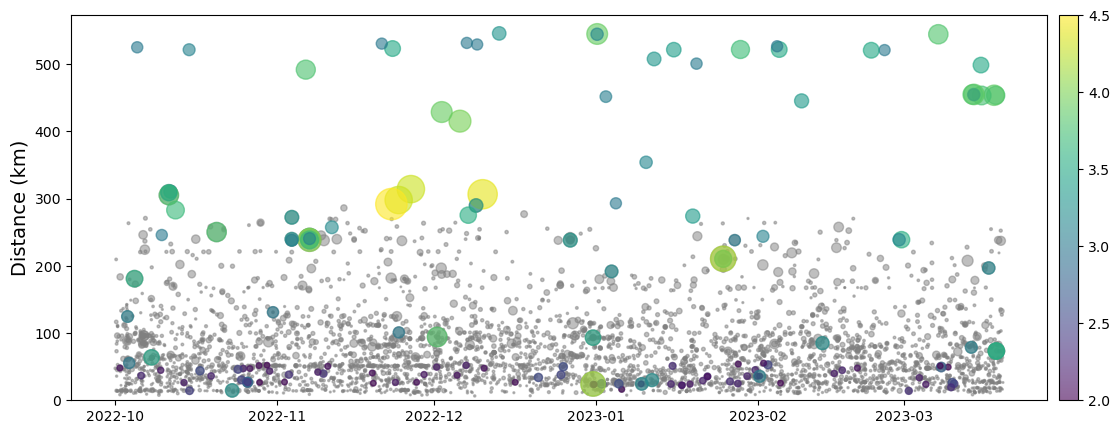

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

cax = ax.scatter(events_df.timestamp, events_df.distances_km, s=4**events_df.magnitude, 
                 c=events_df.magnitude, alpha=0.6, cmap='viridis')

ax.scatter(events_all_df.timestamp, events_all_df.distances_km, s=4**events_all_df.magnitude, c='grey', alpha=0.5, zorder=-1)

plt.colorbar(cax, ax=ax, pad=0.01)

ax.set_ylim(bottom=0)
ax.set_ylabel("Distance (km)", fontsize=14)

# ax.set_xlim(events_all_df.timestamp.min().date(), events_all_df.timestamp.max().date())

plt.show();

## Plot on Map

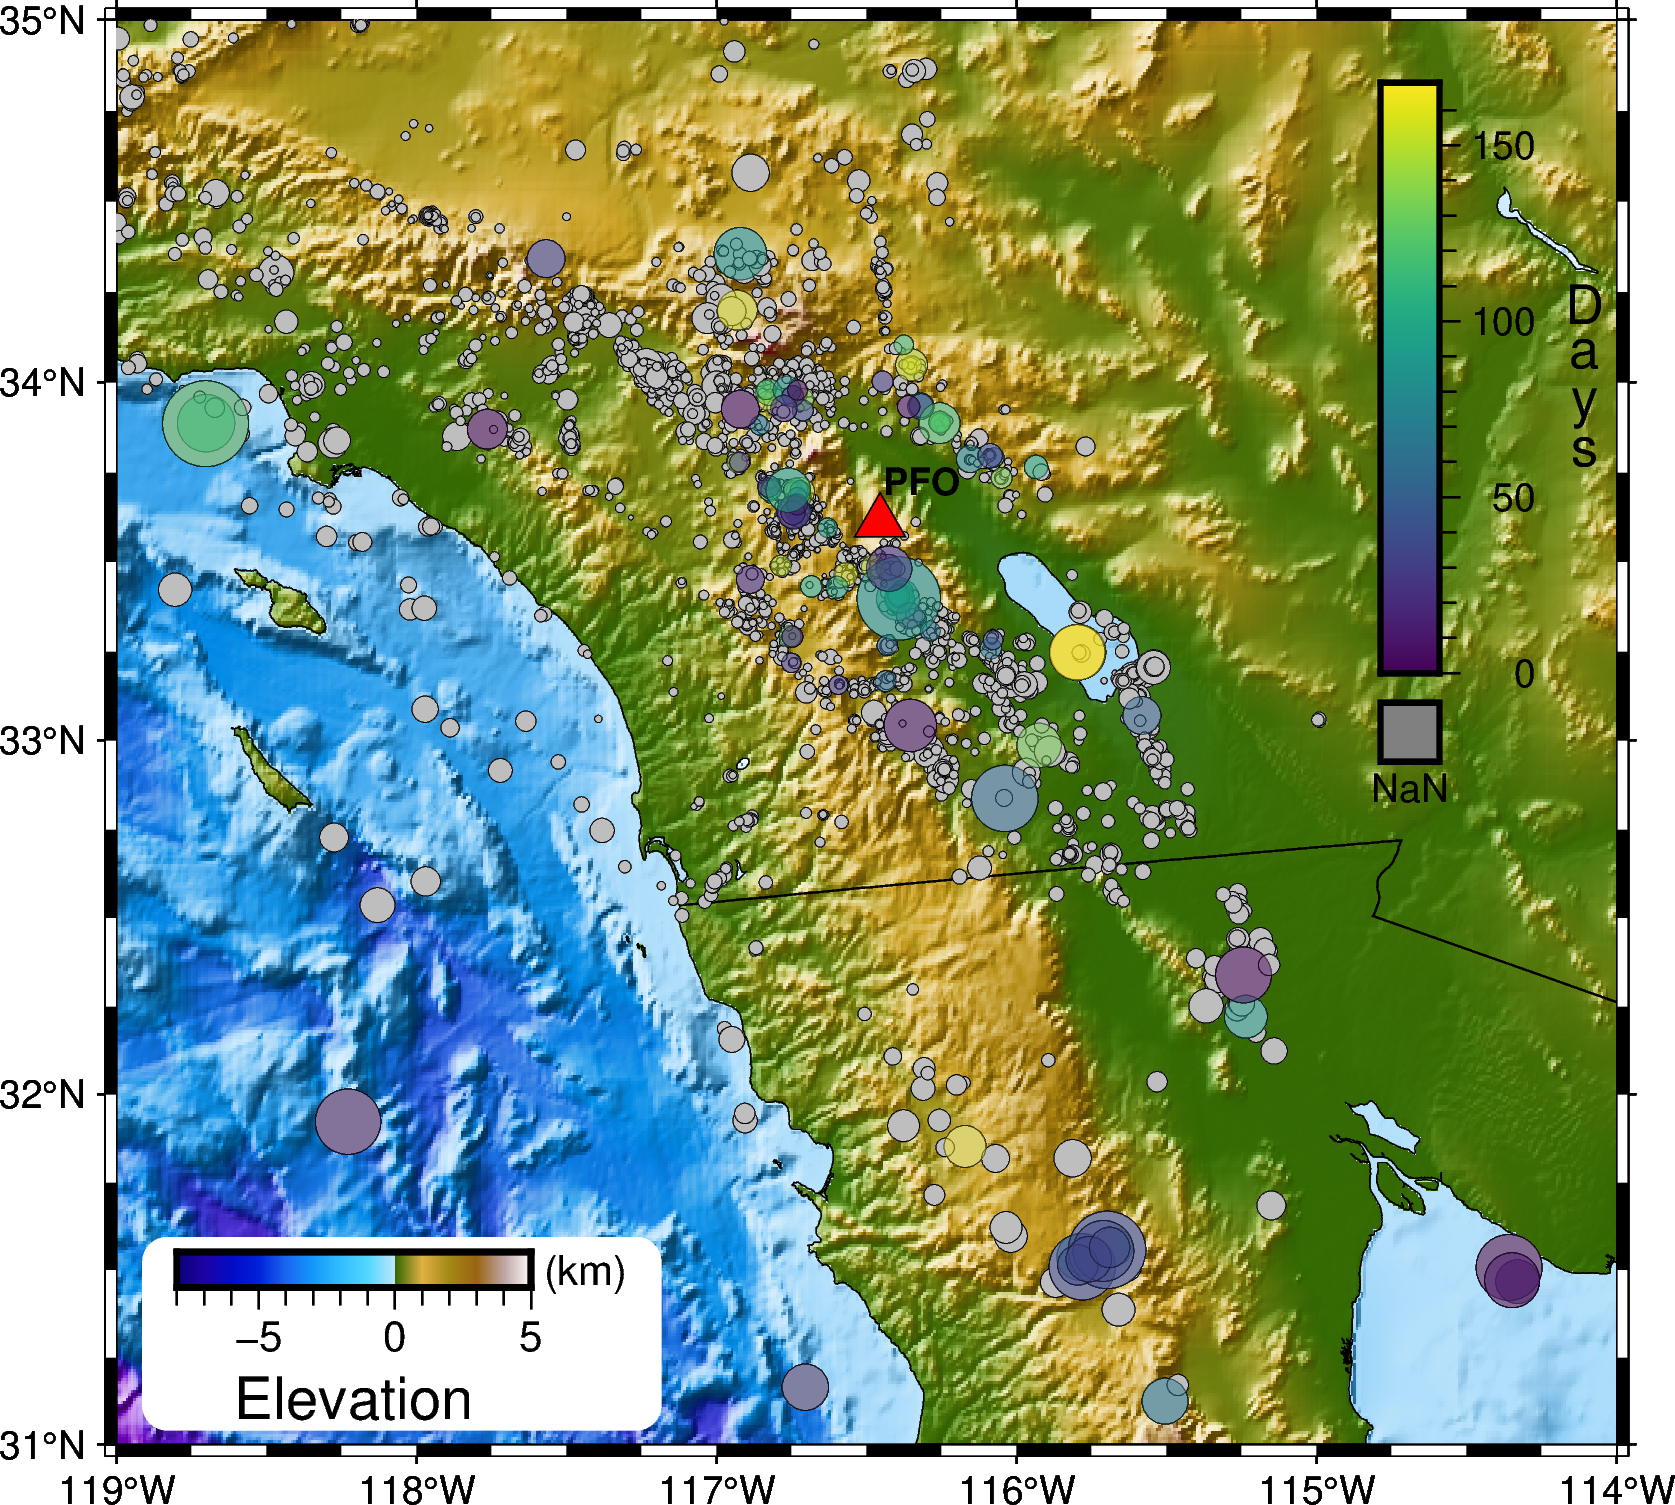

In [143]:
def __makeplot_eventmap(config, data1, data2):
    

    import pygmt
    import pandas as pd

    
    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    resolution = "30s"

    fig = pygmt.Figure()
    
#     fig.basemap(region=region, projection="M15c", frame=True)


    # make color pallets
    cmap = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)
    
    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
    
    ## adjust land and sea/lakes
#     land = topo_data * pygmt.grdlandmask(region=region, 
#                                          spacing=resolution, 
#                                          maskvalues=[0, 1], 
#                                          resolution="f"
#                                         )
    wet = topo_data * pygmt.grdlandmask(region=region, 
                                        spacing=resolution, 
                                        maskvalues=[1, "NaN"], 
                                        resolution="f"
                                       )
    
    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection='M5i',
        shading=True,
        cmap = cmap,
        frame=True,
        nan_transparent=True
    )     


#     cmap_wet = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

    fig.grdimage(
        grid=wet,
        region=region,
        projection='M5i',
        shading=True,
        cmap='seafloor',
        frame=True,
        nan_transparent=True
    )
    
    
    cmap = pygmt.makecpt(cmap='etopo1', series='-8000/5000/1000', continuous=True)    
    fig.colorbar(cmap=cmap, position="g-118.8/31.45+w3c/0.3c+h", box="+gwhite+c0.1+r", 
                 frame=["x+lElevation", r"y+l(km)"], scale=0.001)    


    ## add coastlines
    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)
#     fig.coast(rivers="1/0.5p,blue") # Rivers

    
    ## colorbar colormap
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])

#     cmap_depth = pygmt.makecpt(cmap="rainbow", series=[data1.depth.min()/1000, data1.depth.max()/1000])
    
#     ## plot data coordinates
    fig.plot(
        x=data2.longitude,
        y=data2.latitude,
        size=0.04*2**data2.magnitude,
        fill='grey',
        style="cc",
        pen="0p,black",
    )    

    fig.plot(
        x=data1.longitude,
        y=data1.latitude,
        size=0.04*2**data1.magnitude,
#         fill=data1.depth/1000,
        fill=data1.seconds,
        cmap=True,
        style="cc",
        pen="0.1p,black",
        transparency=50,        
    )    

    ## plot PFO
    fig.plot(
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )
    
    fig.text(
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.35],
        font="9p,Helvetica-Bold,black"
    )

    ## add depth colorbar
#     fig.colorbar(frame='af+l"Depth (km)"', cmap=cmap_depth)
    fig.colorbar(frame='af+l"Days"', cmap=cmap_mag, position="JMR+o-2c/3c+w5c/0.5c+n+mc", scale=1/86400)
    
    ## save figure to file
    fig.savefig(config['outpath']+'tmp_event_map.png')

    fig.show();
    return fig

fig = __makeplot_eventmap(config, events_df, events_all_df)